# Random search

## O que é?

Random search é uma técnica de otimização hiperparamétrica apresentada como técnica eficiente por Bergstra e Bengio que consiste em aleatóriamente selecionar combinações de hiperparâmetros, testá-las e decidir qual a melhor. Inicialmente foi considerada pouco eficiente pois ao selecionar conjuntos de hiperparâmetros de forma aleatória, poderia não selecionar nenhum conjunto satisfatório, contudo Bergstra e Bengio demonstraram que em diversos casos, o método de busca aleatória pode performar tão bem quanto a busca por grade. Segundo Alice Zheng (Evaluating Machine Learning Models) ao selecionar aleatoriamente 60 conjuntos de hiperparâmetros, a probabilidade de um dos conjuntos selecionados estar a menos de 5% do conjunto de melhor resultado é de 95%. 

* Probabilidade de, ao selecionar n pontos nenhum deles estar a 5% do ideal
    * ${(1-0,05)^n}$
* Probabilidade de ao menos um ponto estar dentro do intervalo desejado
    * ${1-(1-0,05)^n}$
* Como queremos como resultado 95% de eficiência:
    * ${1-(1-0,05)^n > 0,95}$
    * n ~ 60

### Exemplo

Exemplo comparativo utilizando modelos padrão e modelos com hiperparâmetros ajustados pela busca aleatória

In [1]:
# importando dependências
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time 
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

In [2]:
#Recolhendo dados do facebook e preparando dataset

import pandas_datareader.data as web
import datetime as dt

end = dt.datetime(2020, 6, 1)
start = dt.datetime(2019, 1, 1)

df = web.DataReader("FB", 'yahoo', start, end)

df = df.reset_index()
df = df.drop(columns=['Open','Date','High','Low','Volume','Adj Close'])
df = df.rename(columns={'Close': 'Close 0'})

def window (df, w):
    for i in range(1,w):
        df['Close '+str(i)] = df['Close '+str(i-1)].shift(1)
    return df
        
df = window(df,5)
df = df.rename(columns={'Close 0': 'Target'})
df.dropna(inplace=True)
df.head()

,Target,Close 1,Close 2,Close 3,Close 4
4,142.529999,138.050003,137.949997,131.740005,135.679993
5,144.229996,142.529999,138.050003,137.949997,131.740005
6,144.199997,144.229996,142.529999,138.050003,137.949997
7,143.800003,144.199997,144.229996,142.529999,138.050003
8,145.389999,143.800003,144.199997,144.229996,142.529999


In [3]:
#Separando dados de treino e teste
X = df.loc[:, ['Close 1','Close 2','Close 3','Close 4']]
y = df.loc[:, 'Target'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

### Criando modelos default

In [4]:
# Random Forest
# n_estimators = 100, criterion = "mse", max_depth = None, min_samples_split = 2, max_features = "auto", 
# oob_score=false, max_samples=none
rf_default = RandomForestRegressor()

#AdaBoost
# n_estimators = 50, learning_rate = 1, loss = 'linear'
adb_default = AdaBoostRegressor()

#GradientBoosting
# loss = 'ls', learning_rate = 0.1, n_estimators=100, subsample = 1.0, criterion = 'friedman_mse', 
# max_features = 'auto', alpha = 0.9
gdb_default = GradientBoostingRegressor()

### Lista de hiperparâmetros

In [5]:
rf_hp = {'n_estimators':[30,50,100,150,300,500,750], 'criterion':['mse','mae'], 'min_samples_split':[2,3,5,7,10,15],
        'max_features':['auto','sqrt','log2'], 'oob_score':[True,False], 'max_samples':[0.3,0.5,0.75,0.8,0.9,0.99,1]}

adb_hp = {'n_estimators':[15,30,50,100,150,300,500], 'learning_rate':[0.3,0.4,0.5,0.75,0.8,0.9,0.99,1.0], 'loss':['linear','square','exponential']}

gdb_hp = {'loss':['ls','lad','huber','quantile'], 'learning_rate':[0.05,0.1,0.2,0.3,0.5,0.75],'n_estimators':[15,30,50,100,150,300,500],
         'subsample':[0.3,0.5,0.7,0.9,1.0], 'criterion': ['friedman_mse','mse','mae'], 'max_features':['auto','sqrt','log2'],
         'alpha':[0.05,0.1,0.3,0.5,0.75,0.9, 0.99]}

### Criando modelos ajustados
* Random forest ajustado
* Adaboost ajustado com estimador padrão
* Adaboost ajustado com estimador = Random Forest ajustado
* GradientBoosting ajustado

In [6]:
rf_tune = RandomizedSearchCV(rf_default, rf_hp, n_iter = 60, cv=5)

adb_tune = RandomizedSearchCV(adb_default, adb_hp, n_iter = 60, cv=5)

gdb_tune = RandomizedSearchCV(gdb_default, gdb_hp, n_iter = 60, cv=5)

### Treinando configurações de modelos 

In [7]:
rf_tune.fit(X_train, y_train)

print(rf_tune.best_params_)

{'oob_score': True, 'n_estimators': 750, 'min_samples_split': 3, 'max_samples': 0.5, 'max_features': 'auto', 'criterion': 'mse'}


In [9]:
adb_tune.fit(X_train, y_train)

print(adb_tune.best_params_)

{'n_estimators': 100, 'loss': 'linear', 'learning_rate': 0.3}


In [9]:
gdb_tune.fit(X_train, y_train)

print(gdb_tune.best_params_)

{'subsample': 1.0, 'n_estimators': 15, 'max_features': 'auto', 'loss': 'ls', 'learning_rate': 0.2, 'criterion': 'mae', 'alpha': 0.1}


### Criando modelos com configurações "ideais"

In [19]:
rf_tuned = RandomForestRegressor(oob_score = True, n_estimators = 30, min_samples_split = 5, max_samples = 0.5, max_features = 'auto', criterion = 'mae')

adb_tuned = AdaBoostRegressor(n_estimators= 30, loss= 'exponential', learning_rate= 0.8)

adb_tuned_rf_tuned = AdaBoostRegressor(base_estimator = rf_tuned, n_estimators= 30, loss= 'exponential', learning_rate= 0.8)

gdb_tuned = GradientBoostingRegressor(subsample= 1.0, n_estimators= 15, max_features= 'auto', loss= 'ls', learning_rate= 0.2, criterion= 'mae', alpha= 0.1)

### Treinando todos modelos

In [20]:
#Modelos padrão
rf_default.fit(X_train,y_train)
adb_default.fit(X_train,y_train)
gdb_default.fit(X_train,y_train)

#Modelos ajustados
rf_tuned.fit(X_train,y_train)
adb_tuned.fit(X_train,y_train)
adb_tuned_rf_tuned.fit(X_train,y_train)
gdb_tuned.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.1, criterion='mae', learning_rate=0.2,
                          max_features='auto', n_estimators=15)

In [21]:
#Pontuações

#Modelos padrão
rf_default_score = rf_default.score(X_test,y_test)
adb_default_score = adb_default.score(X_test,y_test)
gdb_default_score = gdb_default.score(X_test,y_test)

#Modelos ajustados
rf_tuned_score = rf_tuned.score(X_test,y_test)
adb_tuned_score = adb_tuned.score(X_test,y_test)
adb_tuned_rf_tuned_score = adb_tuned_rf_tuned.score(X_test,y_test)
gdb_tuned_score = gdb_tuned.score(X_test,y_test)

In [22]:
#Previsões

#Modelos padrão
rf_default_pred = rf_default.predict(X)
adb_default_pred = adb_default.predict(X)
gdb_default_pred = gdb_default.predict(X)

#Modelos ajustados
rf_tuned_pred = rf_tuned.predict(X)
adb_tuned_pred = adb_tuned.predict(X)
adb_tuned_rf_tuned_pred = adb_tuned_rf_tuned.predict(X)
gdb_tuned_pred = gdb_tuned.predict(X)

In [23]:
print('--RELATÓRIO--')

print('Random Forest:')
print('Default score: ',rf_default_score)
print('Tuned score: ',rf_tuned_score)
print('--------------------')

print('Adaboost:')
print('Default score: ',adb_default_score)
print('Tuned score: ',adb_tuned_score)
print('Tuned + RF tuned score: ',adb_tuned_rf_tuned_score)
print('--------------------')

print('Gradient Boost:')
print('Default score: ',gdb_default_score)
print('Tuned score: ',gdb_tuned_score)
print('--------------------')

--RELATÓRIO--
Random Forest:
Default score:  0.9369265639483985
Tuned score:  0.9463390222930432
--------------------
Adaboost:
Default score:  0.9259634873994085
Tuned score:  0.9293578430028929
Tuned + RF tuned score:  0.9409105587105726
--------------------
Gradient Boost:
Default score:  0.9436143536890905
Tuned score:  0.9466839589816911
--------------------


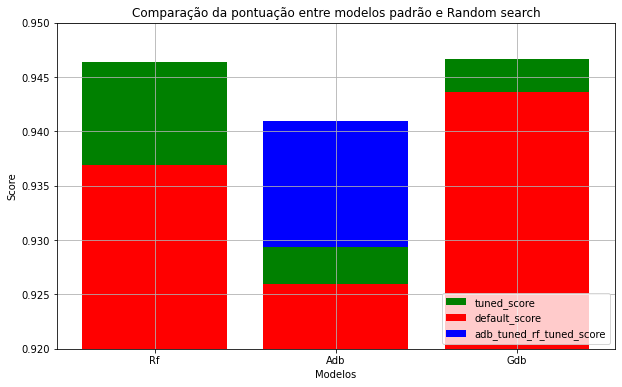

In [30]:
#Visualizando resultados

plt.figure(figsize=(10,6))

plt.bar(0, rf_tuned_score, label='tuned_score', color='green')
plt.bar(0, rf_default_score, label='default_score', color='red')

plt.bar(1, adb_tuned_rf_tuned_score, label='adb_tuned_rf_tuned_score', color='blue')
plt.bar(1, adb_tuned_score, color='green')
plt.bar(1, adb_default_score, color='red')

plt.bar(2, gdb_tuned_score, color='green')
plt.bar(2, gdb_default_score, color='red')

plt.ylim(0.92, 0.95)
plt.ylabel('Score')
plt.xlabel('Modelos')
plt.title('Comparação da pontuação entre modelos padrão e Random search')
plt.legend(loc='lower right')
plt.xticks(np.arange(3),['Rf','Adb','Gdb'])
plt.grid()
plt.show()